In [2]:
import cv2, os, random
import numpy as np
import shutil 
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,concatenate,Input,LSTM, Reshape,Permute
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,Conv2DTranspose,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard

In [3]:
def data_preprocess(root_dir):
  image_files = [] #Listing all Train image files
  for i in os.listdir(root_dir): # getting all train image directories
    path_1= os.path.join(root_dir,i)
    for k in os.listdir(path_1): # images from the directory
      path_2 = os.path.join(path_1,k) #
      image_files.append(path_2)
  return image_files

In [4]:
#Preprocessing of the Image
def process_image(path):
  img = cv2.imread(path)
  img = cv2.resize(img,(320,256))
  img = np.float32(img)/255
  return img

In [5]:
# Unet Model Architecture
def unet(pretrained_weigths=None):
  input = Input(shape = (256,320,3))
  
  conv_1 = Conv2D(64,(3,3),activation='relu', padding = 'same')(input)
  conv_2 = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(conv_1)
  pool_1 =  MaxPooling2D(pool_size =(2,2))(conv_2)
  pool_1 = Dropout(0.5)(pool_1)


  conv_3 = Conv2D(128,(3,3),activation = 'relu', padding = 'same')(pool_1)
  conv_4 = Conv2D(128,(3,3), activation ='relu', padding = 'same')(conv_3)
  pool_2 = MaxPooling2D(pool_size = (2,2))(conv_4)
  pool_2 = Dropout(0.5)(pool_2)


  conv_5 = Conv2D(256,(3,3),activation='relu', padding = 'same')(pool_2)
  conv_6 = Conv2D(256,(3,3),activation = 'relu', padding = 'same')(conv_5)
  pool_3 = MaxPooling2D(pool_size=(2,2))(conv_6)
  pool_3 = Dropout(0.5)(pool_3)

  conv_7 = Conv2D(512,(3,3),activation = 'relu', padding = 'same')(pool_3)
  conv_8 = Conv2D(512,(3,3),activation = 'relu', padding = 'same')(conv_7)
  pool_4 = MaxPooling2D(pool_size=(2,2))(conv_8)
  pool_4 = Dropout(0.5)(pool_4)


  conv_9 =Conv2D(1024,(3,3),activation = 'relu', padding = 'same')(pool_4)
  conv_10 = Conv2D(1024,(3,3),activation ='relu', padding = 'same')(conv_9)

  upconv_1 = Conv2DTranspose(512,(3,3),strides= (2,2),padding='same')(conv_10)
  concat_1 = concatenate([upconv_1,conv_8],axis=3)
  concat_1 = Dropout(0.5)(concat_1)
  
  conv_11 = Conv2D(512,(3,3),activation='relu', padding = 'same')(concat_1)
  conv_12 = Conv2D(512,(3,3),activation='relu', padding = 'same')(conv_11)

  upconv_2 = Conv2DTranspose(256,(3,3),strides = (2,2),padding='same')(conv_12)
  concat_2 = concatenate([upconv_2,conv_6],axis=3)
  concat_2 = Dropout(0.5)(concat_2)

  conv_13 = Conv2D(256,(3,3),activation = 'relu', padding = 'same')(concat_2)
  conv_14 = Conv2D(256,(3,3),activation = 'relu', padding = 'same')(conv_13)

  upconv_3 = Conv2DTranspose(128,(3,3),strides = (2,2),padding='same')(conv_14)
  concat_3 = concatenate([upconv_3,conv_4],axis=3)
  concat_3 = Dropout(0.5)(concat_3)

  conv_15 = Conv2D(128,(3,3),activation='relu', padding = 'same')(concat_3)
  conv_16 = Conv2D(128,(3,3),activation='relu', padding = 'same')(conv_15)

  upconv_4 = Conv2DTranspose(64,(3,3),strides = (2,2),padding='same')(conv_16)
  concat_4 = concatenate([upconv_4,conv_2],axis=3)
  concat_4 = Dropout(0.5)(concat_4)

  conv_17 = Conv2D(64,(3,3),activation='relu', padding = 'same')(concat_4)
  conv_18 =Conv2D(64,(3,3),activation='relu', padding = 'same')(conv_17)
  
  out = Conv2D(7,(1,1),padding='same',activation = 'softmax')(conv_18)
  model = Model(input,out)
  return model

In [11]:
def predict(img_path):
  print('\nWorking on Data Preparation....\n')
  test_images = data_preprocess(img_path)
  X_test = []
  for i in test_images:
    X_test.append(process_image(i))
  X_test = np.array(X_test)
  print('Total number of images:',X_test.shape[0])
  print('\nDone with data preparation.....\n ')
  print('Utilizing unet model....\n')
  unet_model = unet()
  print('loading weights....\n')
  unet_model.load_weights('/content/drive/MyDrive/unet_best_model.h5')
  print('\nWeights Loaded....\n')
  print('\nWorking on Predicting....\n')
  pred = unet_model.predict(X_test)
  
  print("\nPresenting the image segmentation of test data....\n")
  for i in range(0,5):
    image = cv2.imread(test_images[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 256),  interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = pred[i]
    mask = tf.argmax(mask, axis=-1)

    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(131)
    ax1.imshow(image)
    ax1.axis('off')
    ax2=fig.add_subplot(132)
    ax2.imshow(mask)
    ax2.axis('off')
    ax1.title.set_text('Image')
    ax2.title.set_text('Predicted mask')
    plt.show()


Working on Data Preparation....

Total number of images: 404

Done with data preparation.....
 
Utilizing unet model....

loading weights....


Weights Loaded....


Working on Predicting....

13/13 [==============================] - 9s 717ms/step

Presenting the image segmentation of test data....



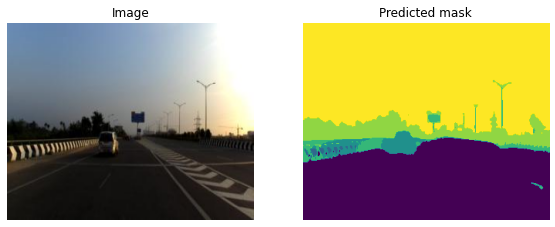

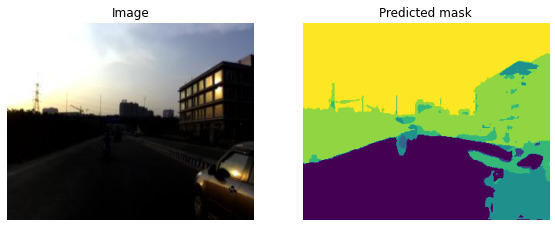

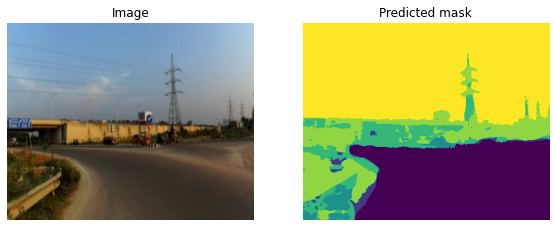

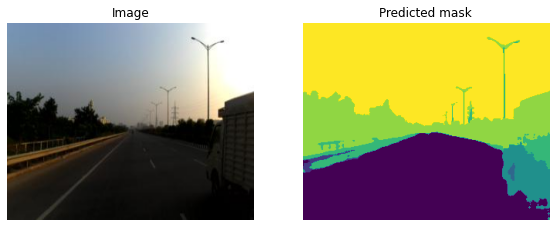

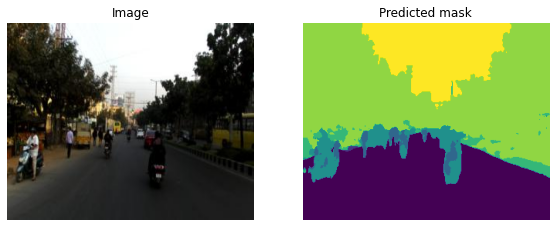

In [12]:
test_path = '/content/drive/MyDrive/idd20k_lite/leftImg8bit/test'
predict(test_path)